In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
code_name="../code_pythia_res_post.pt"
math_name="../math_pythia_res_post.pt"
wiki_name="../wiki_pythia_res_post.pt"
math_acts = torch.load(math_name)
acts = torch.load(wiki_name)
code_acts = torch.load(code_name)

/tmp/ipykernel_19955/762752945.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  math_acts = torch.load(math_name)
/tmp/ipykernel_19955/762752945.py:7: FutureWarning: You 

In [39]:
from typing import List
import sae_lens
from tqdm import tqdm
@torch.no_grad()    
def ablation_extreme_freq(
    model: torch.nn.Module,
    activation: torch.Tensor,
    dataset: torch.utils.data.Dataset,
    sae_list: List[sae_lens.SAE],
    largest: bool = True,
    number: int = 1,
    idx_: torch.tensor = 0,
):
    abl_layer = 1
    doc_len = 0
    freq_mean_global = 0
    layers = 6
    freqs = torch.zeros(layers, sae_list[0].cfg.d_sae).to(device)
    doc_len = int(len(dataset) * 0.001)
    for idx in range(abl_layer):
        list(map(lambda idy: sae_list[idx].W_dec[idy, :].zero_(), idx_))
        list(sae_list[idx].b_dec.zero_())

    for idx in range(doc_len):
        example = dataset[idx]
        tokens = model.to_tokens([example], prepend_bos=True)
        _, cache = model.run_with_cache_with_saes(
            tokens, saes=sae_list, use_error_term=False
        )
        model.reset_saes()

        local_doc_len = cache["blocks.0.hook_resid_post.hook_sae_acts_post"].shape[
            1
        ]
        freq = torch.zeros_like(freqs)
        for layer in range(layers):
            prompt2 = f"blocks.{layer}.hook_resid_post.hook_sae_acts_post"
            
            freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
        new_doc_len = doc_len + local_doc_len
        if idx == 0:
            freq_mean_global = freq
        else:
            freq_mean_global = (
                freq_mean_global * doc_len / new_doc_len
                + freq * local_doc_len / new_doc_len
            )
        doc_len = new_doc_len
    # torch.save(
    #     freq_mean_global,
    #     f"../../res/ablation/abl_tmp_math_pythia_res_post.pt",
    # )
    return freq_mean_global

In [3]:
import datasets
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
sae_list = []
release = "pythia-70m-deduped-res-sm"
sae_id = f"blocks.0.hook_resid_pre"
model_name = "pythia-70m-deduped"

for layer in range(layers):
    sae_id = f"blocks.{layer}.hook_resid_post"
    sae_list.append(
        sae_lens.SAE.from_pretrained(
            release=release, sae_id=sae_id, device=device
        )[0]
    )

model = sae_lens.HookedSAETransformer.from_pretrained(model_name).to(device)
dataset = datasets.load_dataset("hbin0701/abstract_math")["train"]["input"]

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


Loaded pretrained model pythia-70m-deduped into HookedTransformer
Moving model to device:  cuda


In [17]:
wiki_nonzero = (acts[1]>1e-3).nonzero()[:,0]
math_nonzero = (math_acts[1]>1e-3).nonzero()[:,0]
code_nonzero = (code_acts[1]>1e-3).nonzero()[:,0]
print("wiki",wiki_nonzero.shape)
print("math",math_nonzero.shape)
print("code",code_nonzero.shape)

wiki torch.Size([5285])
math torch.Size([2042])
code torch.Size([3412])


In [35]:
wiki_top1k = acts[1].topk(3000)[1]
math_top1k = math_acts[1].topk(3000)[1]
code_top1k = code_acts[1].topk(3000)[1]
iou = set(wiki_top1k.tolist()) & set(math_top1k.tolist()) & set(code_top1k.tolist())
new_act=math_acts[1][torch.tensor(list(iou))]
print("intersection",new_act.shape)

intersection torch.Size([1406])


In [37]:
top_idx = new_act.topk(700)[1]
print(top_idx[:10])

tensor([ 686,  858,  842,  346,  481,  553, 1088,   28,  350, 1236],
       device='cuda:0')


In [40]:
indices = torch.topk(math_acts, 300, largest=True)[1][2:]
perb = [[], [], [], [], []]
high_perb = [[], [], [], [], []]
low_perb = [[], [], [], [], []]
low_high_perb = [[], [], [], [], []]
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
sae_list = []
release = "pythia-70m-deduped-res-sm"
sae_id = f"blocks.0.hook_resid_pre"
model_name = "pythia-70m-deduped"

for layer in range(layers):
    sae_id = f"blocks.{layer}.hook_resid_post"
    sae_list.append(
        sae_lens.SAE.from_pretrained(
            release=release, sae_id=sae_id, device=device
        )[0]
    )
bias_act = torch.load("../../res/ablation/abl_bias_math_pythia_res_post.pt")
for idx in tqdm(range(20)):
    freq_mean_global = ablation_extreme_freq(model=model, activation=math_acts, dataset=dataset, sae_list=sae_list, largest=True, idx_=top_idx[:(idx+1)*30])
    diff = (bias_act[1:]-freq_mean_global[1:])
    for layer in range(5):
        perb[layer].append((diff[layer] > 0.01).nonzero().shape[0])
        low_perb[layer].append((diff[layer] > 0.001).nonzero().shape[0])
        high_perb[layer].append((diff[layer][indices[layer]] > 0.01).nonzero().shape[0])
        low_high_perb[layer].append((diff[layer][indices[layer]] > 0.001).nonzero().shape[0])


/tmp/ipykernel_19955/931926843.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bias_act = torch.load("../../res/ablation/abl_bias_math_pythia_res_post.pt")
100%|███████

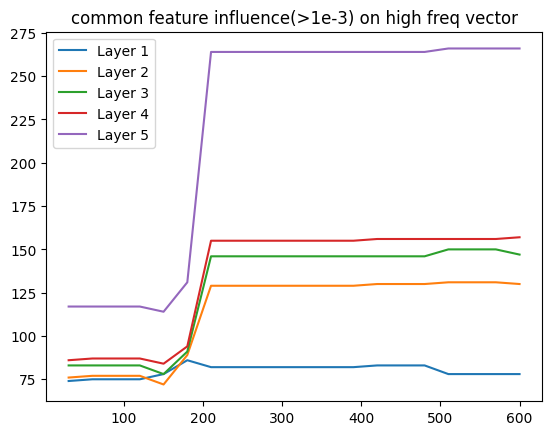

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
import numpy as np

for layer in range(5):
    plt.plot(np.arange(30, 630, 30), low_high_perb[layer], label=f"Layer {layer+1}")
plt.legend()
plt.title('common feature influence(>1e-3) on high freq vector')
plt.show()
plt.savefig("../../res/ablation/abl_low_high_perb_math_pythia_common_res_post.png")

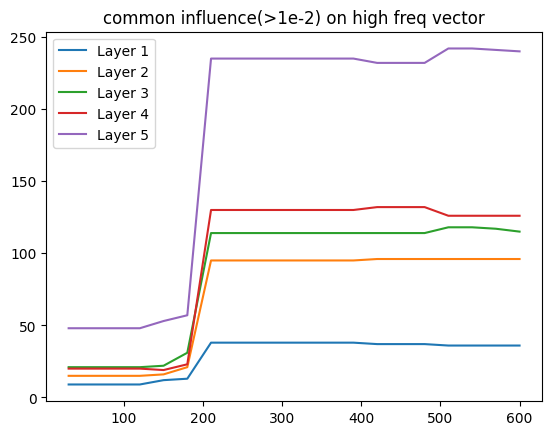

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
import numpy as np

for layer in range(5):
    plt.plot(np.arange(30, 630, 30), high_perb[layer], label=f"Layer {layer+1}")
plt.legend()
plt.title('common influence(>1e-2) on high freq vector')
plt.show()
plt.savefig("../../res/ablation/abl_high_perb_math_pythia_common_res_post.png")

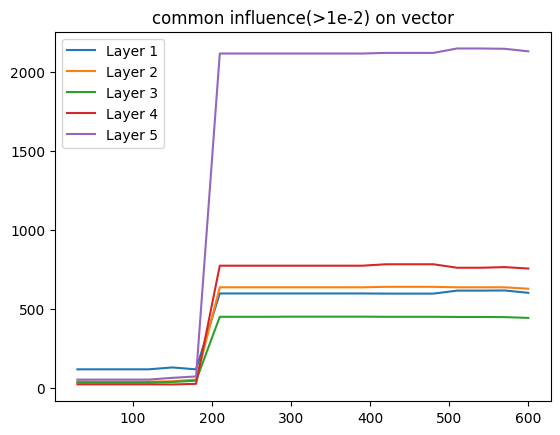

<Figure size 640x480 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
import numpy as np

for layer in range(5):
    plt.plot(np.arange(30, 630, 30), perb[layer], label=f"Layer {layer+1}")
plt.legend()
plt.title('common influence(>1e-2) on vector')
plt.show()
plt.savefig("../../res/ablation/abl_perb_math_pythia_common_res_post.png")

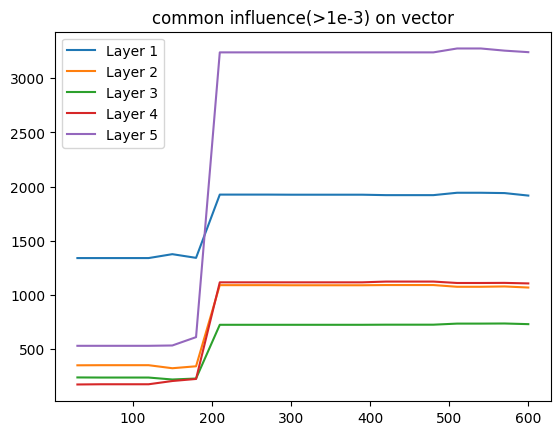

<Figure size 640x480 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
import numpy as np

for layer in range(5):
    plt.plot(np.arange(30, 630, 30), low_perb[layer], label=f"Layer {layer+1}")
plt.legend()
plt.title('common influence(>1e-3) on vector')
plt.show()
plt.savefig("../../res/ablation/abl_low_perb_math_pythia_common_res_post.png")